# LangGraph Streaming Outputs

- Author: [hong-seongmin](https://github.com/hong-seongmin)
- Design: 
- Peer Review: 
- This is a part of [LangChain OpenTutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/10-Retriever/06-MultiQueryRetriever.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/10-Retriever/06-MultiQueryRetriever.ipynb)


## Overview

**LangGraph Streaming Outputs** explores the step-by-step streaming capabilities within LangGraph. 

This approach allows developers to observe and interact with each graph processing stage in real-time, offering insights into the internal workings and progress of graph computations.

- **Step-by-Step Streaming**  
  The streaming functionality breaks down the graph execution into individual steps, providing detailed outputs at each stage. This makes it easier to debug and understand how data flows through the graph, as well as how decisions are made along the way.

- **Real-Time Feedback**  
  By leveraging streaming outputs, users receive immediate feedback from the system. This real-time interaction can greatly enhance the debugging process and the ability to fine-tune graph configurations on the fly.

- **Enhanced Transparency and Control**  
  Streaming outputs offer greater transparency into the execution of LangGraph pipelines. Users can monitor each transformation or computation, enabling more precise control over the process and facilitating a deeper comprehension of complex graph-based workflows.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Step-by-step Streaming Output with LangGraph](#Step-by-step-Streaming-Output-with-LangGraph)
- [The stream Method of StateGraph](#The-stream-Method-of-StateGraph)
- [Advanced Streaming Options](#advanced-streaming-options)

### References

- [LangChain Documentation: LangGraph](https://langchain-ai.github.io/langgraph/tutorials/introduction/)
- [LangChain Documentation: Streaming](https://python.langchain.com/docs/concepts/streaming/)
- [LangChain-ai Github: LangGraph Streaming](https://langchain-ai.github.io/langgraph/concepts/streaming/)

---

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions and utilities for tutorials. 
- You can checkout the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [16]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [17]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain",
        "langchain_core",
        "langchain_openai",
        "langgraph",
        "GoogleNews"
    ],
    verbose=False,
    upgrade=False,
)

In [18]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "10-LangGraph-Streaming-Outputs",
    }
)

Environment variables have been set successfully.


Alternatively, environment variables can also be set using a `.env` file.

**[Note]**

- This is not necessary if you've already set the environment variables in the previous step.

In [19]:
# Configuration file to manage API keys as environment variables
from dotenv import load_dotenv

# Load API key information
load_dotenv(override=True)

True

## Step-by-step Streaming Output with LangGraph

This time, we'll take a closer look at the `stream()` output function in LangGraph.

LangGraph's streaming output function provides the ability to stream each step of the graph.



Note: The LangGraph example below is identical to the example from the previous section.

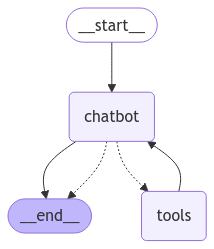

In [20]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from GoogleNews import GoogleNews  # Using GoogleNews library for news search

# Import for Mermaid visualization
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

########## 1. State Definition ##########
# Define state
class State(TypedDict):
    # Add comment for the list of messages
    messages: Annotated[list, add_messages]
    dummy_data: Annotated[str, "dummy"]

########## 2. Tool Definition and Binding ##########
# Tool initialization
# Create a tool to search news by keyword using GoogleNews
news_tool = GoogleNews()

@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    news_tool.search(query)
    results = news_tool.results(sort=True)
    # Limit to top 5 results
    limited_results = results[:5] if results else []
    # Extract title and link from each result
    return [{"title": item["title"], "link": item["link"]} for item in limited_results]

tools = [search_keyword]

# Initialize the LLM
llm = ChatOpenAI(model="gpt-4o-mini")

# Combine tools with LLM
llm_with_tools = llm.bind_tools(tools)

########## 3. Add Nodes ##########
# Define a chatbot function
def chatbot(state: State):
    # Invoke and return messages
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
        "dummy_data": "[chatbot] called, dummy data",  # Add dummy data for testing
    }

# Create a state graph
graph_builder = StateGraph(State)

# Add chatbot node
graph_builder.add_node("chatbot", chatbot)

# Create and add a tool node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Conditional edges
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. Add Edges ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. Compile the Graph ##########

# Compile the graph builder
graph = graph_builder.compile()

########## 6. Visualize the Graph with Mermaid ##########
# Visualize the graph using Mermaid
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


## The stream Method of StateGraph

The `stream` method provides the ability to stream graph steps for a single input.

**Parameters**
- `input` (`Union[dict[str, Any], Any]` ) : Input to the graph
- `config` (`Optional[RunnableConfig]` ) : Execution configuration
- `stream_mode` (`Optional[Union[StreamMode, list[StreamMode]]]` ) : Output streaming mode
- `output_keys` (`Optional[Union[str, Sequence[str]]]` ) : Keys to stream
- `interrupt_before` (`Optional[Union[All, Sequence[str]]]` ) : Nodes to interrupt before execution
- `interrupt_after` (`Optional[Union[All, Sequence[str]]]` ) : Nodes to interrupt after execution
- `debug` (`Optional[bool]` ) : Whether to output debug information
- `subgraphs` (`bool`) : Whether to stream subgraphs

**Returns**
- `Iterator[Union[dict[str, Any], Any]]` : Outputs from each step of the graph. The output format depends on `stream_mode` .

**Key Features**
1. Processes graph execution in a streaming manner according to the given configuration
2. Supports various streaming modes (`values` , `updates` , `debug`)
3. Manages callbacks and error handling
4. Handles recursion limits and interruption conditions

**Streaming Modes**
- `values` : Outputs the current state values at each step
- `updates` : Outputs only state updates at each step
- `debug` : Outputs debug events at each step

In [21]:
from langchain_core.runnables import RunnableConfig

# Question
question = "Please provide the latest news about the 2024 Nobel Prize in Literature."

# Define the initial input state
input = State(dummy_data="Test string", messages=[("user", question)])

# Configure config
config = RunnableConfig(
    recursion_limit=10,  # Visit up to 10 nodes; beyond that, RecursionError will occur
    configurable={"thread_id": "1"},  # Set the thread ID
    tags=["my-tag"],  # Tag
)

We set up the `config` and proceed with streaming output.

In [22]:
for event in graph.stream(input=input, config=config):
    for key, value in event.items():
        print(f"\n[ {key} ]\n")
        # If messages exist in value
        if "messages" in value:
            messages = value["messages"]
            # Print only the most recent message
            value["messages"][-1].pretty_print()


[ chatbot ]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_a9QA6AiVxJjPvTJbd92lPbiw)
 Call ID: call_a9QA6AiVxJjPvTJbd92lPbiw
  Args:
    query: 2024 Nobel Prize in Literature

[ tools ]

================================= Tool Message =================================
Name: search_keyword

[{"title": "We Do Not Part is Han Kang’s most ambitious work yet", "link": "https://chicagoreader.com/books/book-review/we-do-not-part-han-kang/&ved=2ahUKEwikieP5xImLAxUvsFYBHd8MEEMQxfQBegQICBAC&usg=AOvVaw17aQ9BgzWGdDWg5upvavvj"}, {"title": "2024 Nobel Prize for Literature #KoreaNetPerson of the Year #Vegetarian #TheBoy Is ComingNovelist H..", "link": "https://www.mk.co.kr/en/culture/11206720&ved=2ahUKEwikieP5xImLAxUvsFYBHd8MEEMQxfQBegQICRAC&usg=AOvVaw3ZUIOTxml6j8wvurAioOGU"}, {"title": "S. Korea's Han Kang receives Nobel literature prize amid turmoil at home", "link": "https://english.kyodonews.net/news/2024/12/45926507c4d5-s-kore

## Advanced Streaming Options

Advanced streaming options in LangGraph allow for more fine-grained control over how graph execution outputs are handled. By configuring parameters like `output_keys`, `stream_mode`, `interrupt_before`, and `interrupt_after`, users can tailor the streaming behavior to their specific debugging and monitoring needs.


### The output_keys Option

The `output_keys` option is used to specify which keys to stream.

You can specify it in list format, and it must be one of the keys defined in **channels**.

**Tip**

- If a large number of State keys is output at each step, this is useful when you only want to stream some of them.

In [23]:
# Print the list of keys defined in channels
print(list(graph.channels.keys()))

['messages', 'dummy_data', '__start__', 'chatbot', 'tools', 'branch:__start__:__self__:chatbot', 'branch:__start__:__self__:tools', 'branch:chatbot:__self__:chatbot', 'branch:chatbot:__self__:tools', 'branch:tools:__self__:chatbot', 'branch:tools:__self__:tools', 'start:chatbot', 'branch:chatbot:tools_condition:tools']


In [24]:
# Question
question = "Please provide the latest news about the 2024 Nobel Prize in Literature."

# Define the initial input State
input = State(dummy_data="Test string", messages=[("user", question)])

# Configure config
config = RunnableConfig(
    recursion_limit=10,  # Visit up to 10 nodes; beyond that, RecursionError will occur
    configurable={"thread_id": "1"},  # Set the thread ID
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    output_keys=["dummy_data"],  # Try adding messages!
):
    for key, value in event.items():
        # key is the node name
        print(f"\n[ {key} ]\n")

        # If dummy_data exists
        if value:
            # value is the node output
            print(value.keys())
            if "dummy_data" in value:
                print(value["dummy_data"])


[ chatbot ]

dict_keys(['dummy_data'])
[chatbot] called, dummy data

[ tools ]


[ chatbot ]

dict_keys(['dummy_data'])
[chatbot] called, dummy data


In [25]:
# Question
question = "Please provide the latest news about the 2024 Nobel Prize in Literature."

# Define the initial input State
input = State(dummy_data="Test string", messages=[("user", question)])

# Configure config
config = RunnableConfig(
    recursion_limit=10,  # Visit up to 10 nodes; beyond that, RecursionError will occur
    configurable={"thread_id": "1"},  # Set the thread ID
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    output_keys=["messages"],  # Only output messages
):
    for key, value in event.items():
        # If messages exist
        if value and "messages" in value:
            # key is the node name
            print(f"\n[ {key} ]\n")
            # Print the content of the last message
            print(value["messages"][-1].content)


[ chatbot ]



[ tools ]

[{"title": "We Do Not Part is Han Kang’s most ambitious work yet", "link": "https://chicagoreader.com/books/book-review/we-do-not-part-han-kang/&ved=2ahUKEwj2h9CFxYmLAxV6klYBHcDiKqgQxfQBegQICBAC&usg=AOvVaw3jYW04OKoIxGH_sgMIenuZ"}, {"title": "2024 Nobel Prize for Literature #KoreaNetPerson of the Year #Vegetarian #TheBoy Is ComingNovelist H..", "link": "https://www.mk.co.kr/en/culture/11206720&ved=2ahUKEwj2h9CFxYmLAxV6klYBHcDiKqgQxfQBegQICRAC&usg=AOvVaw190Hz6ubn7ksSuhWWP7O_P"}, {"title": "Author Han Kang receives Nobel Prize in Literature at awards ceremony in Stockholm", "link": "https://koreajoongangdaily.joins.com/news/2024-12-11/culture/books/Author-Han-Kang-receives-Nobel-Prize-in-Literature-at-awards-ceremony-in-Stockholm/2197328&ved=2ahUKEwj2h9CFxYmLAxV6klYBHcDiKqgQxfQBegQIAxAC&usg=AOvVaw37fTur2s0T9Bc6uTF0-fj7"}, {"title": "S. Korea's Han Kang receives Nobel literature prize amid turmoil at home", "link": "https://english.kyodonews.net/news/2024/12/4592

### The stream_mode Option

The `stream_mode` option is used to specify the streaming output mode.

- `values`: Outputs the current state values at each step
- `updates`: Outputs only state updates at each step (default)

### stream_mode = "values"

In `values` mode, the current state values of each step are output.

**Note**

`event.items()`

- `key`: Key of the State
- `value`: The value corresponding to the key of the State

In [26]:
# Question
question = "Please provide the latest news about the 2024 Nobel Prize in Literature."

# Define the initial input State
input = State(dummy_data="Test string", messages=[("user", question)])

# Configure config
config = RunnableConfig(
    recursion_limit=10,  # Visit up to 10 nodes; beyond that, RecursionError will occur
    configurable={"thread_id": "1"},  # Set the thread ID
    tags=["my-rag"],  # Tag
)

# Stream output in values mode
for event in graph.stream(
    input=input,
    stream_mode="values",  # Default
):
    for key, value in event.items():
        # key is the State key
        print(f"\n[ {key} ]\n")
        if key == "messages":
            print(f"Number of messages: {len(value)}")
    print("===" * 10, " Step ", "===" * 10)


[ messages ]

Number of messages: 1

[ dummy_data ]

==============================  Step  ==============================

[ messages ]

Number of messages: 2

[ dummy_data ]

==============================  Step  ==============================

[ messages ]

Number of messages: 3

[ dummy_data ]

==============================  Step  ==============================

[ messages ]

Number of messages: 4

[ dummy_data ]

==============================  Step  ==============================


### stream_mode = "updates"

In `updates` mode, only the updated State for each step is output.

- The output is a dictionary whose key is the node name, and values are the updated outputs.

**Note**

`event.items()`

- `key`: The node name
- `value`: The output of that node in dictionary form (it can have multiple key-value pairs).

In [27]:
# Question
question = "Please provide the latest news about the 2024 Nobel Prize in Literature."

# Define the initial input State
input = State(dummy_data="Test string", messages=[("user", question)])

# Configure config
config = RunnableConfig(
    recursion_limit=10,  # Visit up to 10 nodes; beyond that, RecursionError will occur
    configurable={"thread_id": "1"},  # Set the thread ID
    tags=["my-rag"],  # Tag
)

# Stream output in updates mode
for event in graph.stream(
    input=input,
    stream_mode="updates",  # Default
):
    for key, value in event.items():
        # key is the node name
        print(f"\n[ {key} ]\n")

        # value is the output of the node
        print(value.keys())

        # The state is stored in dict form under the keys of 'values'
        if "messages" in value:
            print(f"Number of messages: {len(value['messages'])}")
    print("===" * 10, " Step ", "===" * 10)


[ chatbot ]

dict_keys(['messages', 'dummy_data'])
Number of messages: 1
==============================  Step  ==============================

[ tools ]

dict_keys(['messages'])
Number of messages: 1
==============================  Step  ==============================

[ chatbot ]

dict_keys(['messages', 'dummy_data'])
Number of messages: 1
==============================  Step  ==============================


### The interrupt_before and interrupt_after Options

The `interrupt_before` and `interrupt_after` options are used to specify when to interrupt streaming.

- `interrupt_before`: Interrupt streaming before the specified node
- `interrupt_after`: Interrupt streaming after the specified node


In [28]:
# Question
question = "Please provide the latest news about the 2024 Nobel Prize in Literature."

# Define the initial input State
input = State(dummy_data="Test string", messages=[("user", question)])

# Configure config
config = RunnableConfig(
    recursion_limit=10,  # Visit up to 10 nodes; beyond that, RecursionError will occur
    configurable={"thread_id": "1"},  # Set the thread ID
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",  # Default
    interrupt_before=["tools"],  # Interrupt before the 'tools' node
):
    for key, value in event.items():
        # key is the node name
        print(f"\n[{key}]\n")

        # value is the node's output
        if isinstance(value, dict):
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # The state is stored as a dict (keys of 'values')
        if "messages" in value:
            print(f"Number of messages: {len(value['messages'])}")
    print("===" * 10, " Step ", "===" * 10)


[chatbot]

dict_keys(['messages', 'dummy_data'])
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LL5xawSetOyJGml15BVMzGha', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 58, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-022ff197-23e6-42de-82e4-d5d57f15d7e7-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 Nobel Prize in Literature'}, 'id': 'call_LL5xawSetOyJGml15BVMzGha', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 20, 'total_tokens': 78

In [29]:
# Question
question = "Please provide the latest news about the 2024 Nobel Prize in Literature."

# Define the initial input State
input = State(dummy_data="Test string", messages=[("user", question)])

# Configure config
config = RunnableConfig(
    recursion_limit=10,  # Visit up to 10 nodes; beyond that, RecursionError will occur
    configurable={"thread_id": "1"},  # Set the thread ID
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",
    interrupt_after=["tools"],  # Interrupt after executing 'tools'
):
    for value in event.values():
        # key is the node name
        print(f"\n[{key}]\n")

        if isinstance(value, dict):
            # value is the node's output
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # The state is stored as a dict (keys of 'values')
        if "messages" in value:
            print(f"Number of messages: {len(value['messages'])}")


[__interrupt__]

dict_keys(['messages', 'dummy_data'])
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_isKC85TbbCIdWDhhQiWbUsNv', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 58, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e06fd180-ec4e-4773-899c-9414072be3ca-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024 Nobel Prize in Literature'}, 'id': 'call_isKC85TbbCIdWDhhQiWbUsNv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 20, 'total_token